In [1]:
#Import Packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
#Load Dataset from previous Assignment 
df = pd.read_csv('df_Milestone1.csv')
pd.set_option('display.max_columns', None)

df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,player1_id,player1_seed,player1_entry,player1_name,player1_hand,player1_ht,player1_ioc,player1_age,player2_id,player2_seed,player2_entry,player2_name,player2_hand,player2_ht,player2_ioc,player2_age,best_of,round,duration,player1_rank,player2_rank,age_diff,age_avg,rank_diff,rank_avg,ht_diff,seed_matchup,entry_matchup,residuals,tourney_date_centered,age_avg_centered,rank_diff_centered,age_avg_centered_sq,rank_diff_centered_sq
0,1975-2023,Fairfield,Carpet,32,A,1970,29,100058,-1.0,Regular,Roger Taylor,L,183.0,GBR,33.3,100272,-1.0,Regular,Sandy Mayer,R,178.0,USA,22.8,3,F,135.0,41.0,55.0,10.5,28.05,14.0,48.0,5.0,Both Unseeded,Both Regular,39.979278,-305294.961173,2.125736,-63.011229,4.518755,3970.415019
1,1987-414,Hamburg,Clay,56,A,1970,55,101036,2.0,Regular,Miloslav Mecir,R,190.0,SVK,22.9,100656,1.0,Regular,Ivan Lendl,R,188.0,USA,27.1,5,F,136.0,1.0,5.0,4.2,25.00,4.0,3.0,2.0,Both Seeded,Both Regular,4.261221,-185091.961173,-0.924264,-73.011229,0.854263,5330.639605
2,1991-339,Adelaide,Hard,32,A,1970,14,101441,-1.0,Regular,Martin Sinner,R,180.0,GER,22.8,101117,-1.0,Regular,Eric Jelen,R,180.0,GER,25.8,3,R32,89.0,111.0,68.0,3.0,24.30,43.0,89.5,0.0,Both Unseeded,Both Regular,-6.020722,-154287.961173,-1.624264,-34.011229,2.638232,1156.763719
3,1991-339,Adelaide,Hard,32,A,1970,13,101440,7.0,Regular,Mark Koevermans,R,185.0,NED,22.9,101185,-1.0,WC,Mark Woodforde,L,188.0,AUS,25.2,3,R32,99.0,101.0,48.0,2.3,24.05,53.0,74.5,3.0,Seeded vs Unseeded,Regular vs Special,3.979278,-154287.961173,-1.874264,-24.011229,3.512864,576.539133
4,1991-339,Adelaide,Hard,32,A,1970,12,101061,-1.0,Regular,Jimmy Arias,R,175.0,USA,26.3,101511,3.0,Regular,Horst Skoff,R,175.0,AUT,22.3,3,R32,80.0,60.0,26.0,4.0,24.30,34.0,43.0,0.0,Seeded vs Unseeded,Both Regular,-15.020722,-154287.961173,-1.624264,-43.011229,2.638232,1849.965847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86198,2022-0605,Tour Finals,Hard,8,F,1970,290,126774,2.0,Regular,Stefanos Tsitsipas,R,193.0,GRE,24.2,126094,6.0,Regular,Andrey Rublev,R,188.0,RUS,25.0,3,RR,102.0,7.0,3.0,0.8,24.60,4.0,5.0,5.0,Both Seeded,Both Regular,6.979278,165595.038827,-1.324264,-73.011229,1.753674,5330.639605
86199,2022-0605,Tour Finals,Hard,8,F,1970,289,126774,2.0,Regular,Stefanos Tsitsipas,R,193.0,GRE,24.2,104925,7.0,Regular,Novak Djokovic,R,188.0,SRB,35.4,3,RR,98.0,8.0,3.0,11.2,29.80,5.0,5.5,5.0,Both Seeded,Both Regular,2.979278,165595.038827,3.875736,-72.011229,15.021332,5185.617146
86200,2022-0605,Tour Finals,Hard,8,F,1970,287,106421,4.0,Regular,Daniil Medvedev,R,198.0,RUS,26.7,104925,7.0,Regular,Novak Djokovic,R,188.0,SRB,35.4,3,RR,191.0,8.0,5.0,8.7,31.05,3.0,6.5,10.0,Both Seeded,Both Regular,95.979278,165595.038827,5.125736,-74.011229,26.273173,5477.662064
86201,2022-0605,Tour Finals,Hard,8,F,1970,286,104925,7.0,Regular,Novak Djokovic,R,188.0,SRB,35.4,126094,6.0,Regular,Andrey Rublev,R,188.0,RUS,25.0,3,RR,67.0,8.0,7.0,10.4,30.20,1.0,7.5,0.0,Both Seeded,Both Regular,-28.020722,165595.038827,4.275736,-76.011229,18.281921,5777.706981


In [3]:
# Running Original Model 
# Define the candidate variables
candidate_vars = [
    'surface', 'tourney_level', 'round', 'draw_size',
    'best_of', 'player1_seed', 'player2_seed',
    'age_diff', 'age_avg', 'rank_diff',
    'rank_avg', 'ht_diff']

# Build the formula string
formula = 'duration ~ ' + ' + '.join(candidate_vars)

# Fit the model
model = smf.ols(formula=formula, data=df).fit()

# summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     666.0
Date:                Sun, 27 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:54:26   Log-Likelihood:            -4.1832e+05
No. Observations:               86203   AIC:                         8.367e+05
Df Residuals:                   86177   BIC:                         8.369e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             61.0946     22

## Forward Selection 

In [4]:
# Forward Selection 
selected_vars = []
final_model = None

while candidate_vars:
    results = []

    for var in candidate_vars:
        current_vars = selected_vars + [var]
        formula = 'duration ~ ' + ' + '.join(current_vars)
        model = smf.ols(formula=formula, data=df).fit()

        # Get p-value of the newly added variable only
        p_val = model.pvalues[var] if var in model.pvalues else 1.0
        results.append((p_val, var, model))

    # Sort by p-value ascending (lowest p-value first)
    results.sort(key=lambda x: x[0])
    best_p_val, best_var, best_model = results[0]

    # Only add if p < 0.05
    if best_p_val < 0.05:
        selected_vars.append(best_var)
        candidate_vars.remove(best_var)
        final_model = best_model
        print(f"Added: {best_var}, p-value: {best_p_val:.4f}")
    else:
        break

# Final model output
print("\nForward Selection Model Summary:")
print(final_model.summary())


Added: draw_size, p-value: 0.0000
Added: best_of, p-value: 0.0000
Added: rank_diff, p-value: 0.0000
Added: age_avg, p-value: 0.0000
Added: player2_seed, p-value: 0.0000
Added: rank_avg, p-value: 0.0000
Added: player1_seed, p-value: 0.0000
Added: age_diff, p-value: 0.0126

Forward Selection Model Summary:
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     1951.
Date:                Sun, 27 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:54:40   Log-Likelihood:            -4.1876e+05
No. Observations:               86203   AIC:                         8.375e+05
Df Residuals:                   86194   BIC:                         8.376e+05
Df Model:                           8                         

## Step-wise Selection 

In [5]:
# All candidate predictors
candidate_vars = [
    'surface', 'tourney_level', 'round', 'draw_size',
    'best_of', 'player1_seed', 'player2_seed',
    'age_diff', 'age_avg', 'rank_diff',
    'rank_avg', 'ht_diff'
]

selected_vars = []
final_model = None
threshold_in = 0.05
threshold_out = 0.05

while True:
    changed = False

    # forward step 
    remaining_vars = list(set(candidate_vars) - set(selected_vars))
    new_pvals = []

    for var in remaining_vars:
        formula = 'duration ~ ' + ' + '.join(selected_vars + [var])
        model = smf.ols(formula=formula, data=df).fit()
        pval = model.pvalues[var] if var in model.pvalues else 1
        new_pvals.append((pval, var, model))

    if new_pvals:
        best_pval, best_var, best_model = sorted(new_pvals)[0]
        if best_pval < threshold_in:
            selected_vars.append(best_var)
            final_model = best_model
            changed = True
            print(f"Added: {best_var}, p-value: {best_pval:.4f}")

    # backward step 
    if selected_vars:
        model = smf.ols(formula='duration ~ ' + ' + '.join(selected_vars), data=df).fit()
        worst_pval = model.pvalues.drop('Intercept').max()
        if worst_pval > threshold_out:
            worst_var = model.pvalues.drop('Intercept').idxmax()
            selected_vars.remove(worst_var)
            final_model = smf.ols(formula='duration ~ ' + ' + '.join(selected_vars), data=df).fit()
            changed = True
            print(f"Removed: {worst_var}, p-value: {worst_pval:.4f}")

    if not changed:
        break

# Show final model
print("\nStepwise Model Summary:")
print(final_model.summary())

Added: best_of, p-value: 0.0000
Added: rank_diff, p-value: 0.0000
Added: age_avg, p-value: 0.0000
Added: player2_seed, p-value: 0.0000
Added: rank_avg, p-value: 0.0000
Added: player1_seed, p-value: 0.0000
Added: age_diff, p-value: 0.0120

Stepwise Model Summary:
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     2230.
Date:                Sun, 27 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:54:53   Log-Likelihood:            -4.1876e+05
No. Observations:               86203   AIC:                         8.375e+05
Df Residuals:                   86195   BIC:                         8.376e+05
Df Model:                           7                                         
Covariance Type:          

## Lasso Regression 

In [6]:
# Step 1: Copy relevant columns only
candidate_vars = ['duration',
    'surface', 'tourney_level', 'round', 'draw_size',
    'best_of', 'player1_seed', 'player2_seed',
    'age_diff', 'age_avg', 'rank_diff',
    'rank_avg', 'ht_diff']

df_lasso = df[candidate_vars].copy()

# Convert categorical variables to dummies
df_lasso = pd.get_dummies(df_lasso, drop_first=True)

# Define predictors and response
X = df_lasso.drop(columns='duration')
y = df_lasso['duration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Lasso (with estimate tuning parameter)
lam = 0.001
lasso = Lasso(alpha=lam).fit(X_train_scaled, y_train)
print(f'Lasso Intercept: {lasso.intercept_}')
lasso_coef = pd.DataFrame({'Predictor': X.columns, 'Lasso Coefficient': lasso.coef_})
print(lasso_coef)

# predict and MSE
y_pred = lasso.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Testing MSE (Lasso) lambda = {lam}: {mse:.4f}')



Lasso Intercept: 100.4191438763377
          Predictor  Lasso Coefficient
0         draw_size           1.691653
1           best_of          12.630115
2      player1_seed           0.103268
3      player2_seed           0.460997
4          age_diff           0.265175
5           age_avg           1.655364
6         rank_diff          -2.906326
7          rank_avg           1.722503
8           ht_diff          -0.092563
9      surface_Clay           2.603582
10    surface_Grass          -0.444029
11     surface_Hard           1.217170
12  tourney_level_D           0.782798
13  tourney_level_F           0.701197
14  tourney_level_G           0.137787
15  tourney_level_M           0.821332
16         round_ER          -0.198107
17          round_F           1.095098
18         round_QF           0.334664
19       round_R128          -1.519191
20        round_R16          -0.014809
21        round_R32          -1.056263
22        round_R64          -1.438121
23         round_RR          

C:\Users\jared\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e+05, tolerance: 7.928e+03
  model = cd_fast.enet_coordinate_descent(


## Cross Validation for Lasso 

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Prepalpha values
lambda_grid = {'alpha': np.arange(0.001, 0.101, 0.001)}

# 5-fold cross-validation
lasso_grid = GridSearchCV(estimator=Lasso(), param_grid=lambda_grid,
                          scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_scaled, y)


C:\Users\jared\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e+05, tolerance: 8.093e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\jared\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.410e+04, tolerance: 8.036e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\jared\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+05, toleranc

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])},
             scoring='neg_mean_squared_error')

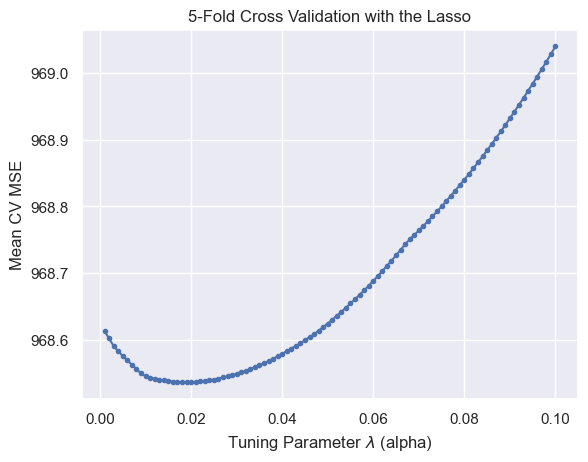

In [9]:
sns.set_theme(style="darkgrid")
plt.plot(lasso_grid.param_grid['alpha'], -lasso_grid.cv_results_['mean_test_score'], marker='.')
plt.xlabel('Tuning Parameter $\\lambda$ (alpha)')
plt.ylabel('Mean CV MSE')
plt.title('5-Fold Cross Validation with the Lasso')
plt.show()


In [10]:
# Best lambda
best_alpha = lasso_grid.best_params_['alpha']
print(f"Best alpha (lambda): {best_alpha}")

# Refit Lasso using the best alpha
lasso = Lasso(alpha=best_alpha).fit(X_scaled, y)

# Show intercept and coefficients
print(f'Lasso Intercept: {lasso.intercept_}')
lasso_coef = pd.DataFrame({
    'Predictor': X.columns,
    'Lasso Coefficient': lasso.coef_})

# Print 
print(lasso_coef[lasso_coef['Lasso Coefficient'] != 0])


Best alpha (lambda): 0.019000000000000003
Lasso Intercept: 100.39193531547626
          Predictor  Lasso Coefficient
0         draw_size           1.702598
1           best_of          12.684559
2      player1_seed           0.220806
3      player2_seed           0.492910
4          age_diff           0.268403
5           age_avg           1.539176
6         rank_diff          -2.828002
7          rank_avg           1.629722
8           ht_diff          -0.089727
9      surface_Clay           2.430459
10    surface_Grass          -0.519814
11     surface_Hard           1.056982
12  tourney_level_D           0.608977
13  tourney_level_F           0.542036
15  tourney_level_M           0.707969
16         round_ER          -0.117673
17          round_F           1.064764
18         round_QF           0.582175
19       round_R128          -1.157887
20        round_R16           0.353123
21        round_R32          -0.639683
22        round_R64          -1.022964
24         round_SF      